# XGBoost-Classification Classifier
---

### Objectives:

- Use XGBoost classifier to classify data

- Apply XGBoost classifier on a real world data set

### Installs:

In [0]:
%%capture
%pip install numpy==2.4.0
%pip install pandas==2.3.3
%pip install scikit-learn==1.8.0
%pip install matplotlib==3.10.8
%pip install seaborn==0.13.0
%pip install xgboost==3.1.3

In [0]:
# Command to restart the kernel and update the installed libraries
%restart_python

### Imports:

In [0]:
# Data Analize and Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data Modeling / Model Linear / Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [0]:
df = pd.read_csv('./data/drug200.csv')

### Verify successful load with some randomly selected records


In [0]:
df.sample(9)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
98,20,M,HIGH,NORMAL,35.639,drugY
196,16,M,LOW,HIGH,12.006,drugC
152,55,M,NORMAL,NORMAL,7.261,drugX
86,51,F,NORMAL,HIGH,13.597,drugX
176,48,M,HIGH,NORMAL,10.446,drugA
157,53,M,LOW,HIGH,22.963,drugY
188,65,M,HIGH,NORMAL,34.997,drugY
167,57,F,NORMAL,HIGH,14.216,drugX
119,61,F,HIGH,HIGH,25.475,drugY


### Understand the data
---

These data are about a group of patients, all with the same disease. During treatment, each patient responded to one of five medications: Medication A, Medication B, Medication C, Medication X, and Medication Y.

The goal is to build a model to discover which medication would be most suitable for a future patient with the same disease. The characteristics of this dataset are the patients' age, sex, blood pressure, and cholesterol, and the objective is to determine which medication each patient responded to.


* **Age** *Continuous* -Patient's age

* **Sex** *Categorical* -Patient's gender (F = Female, M = Male)

* **BP** *Categorical* -Blood Pressure levels (LOW, NORMAL, HIGH)

* **Cholesterol** *Categorical* -Serum Cholesterol levels (NORMAL, HIGH)

* **Na_to_K** *Continuous* -Sodium to Potassium ratio in blood

* **Drug** *Categorical* -Type of drug suitable for the patient (Target Variable)

### Explore the data
First, consider a statistical summary of the data.

In [0]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


### Check distribution of target variable

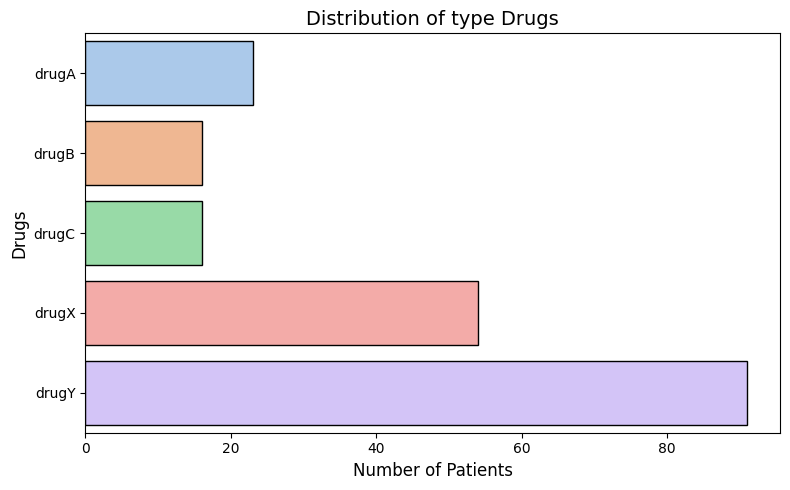

In [0]:
level_order = [
    'drugA', 
    'drugB', 
    'drugC', 
    'drugX', 
    'drugY', 
]

# Figure
plt.figure(figsize = (8, 5))

# Count Plot
ax = sns.countplot(
    y = 'Drug',
    data = df,
    order = level_order,
    edgecolor = 'black',
    palette = 'pastel',
)

plt.title('Distribution of type Drugs', fontsize = 14)
plt.xlabel('Number of Patients', fontsize = 12)
plt.ylabel('Drugs', fontsize = 12)

plt.tight_layout()
plt.show()

In [0]:
df['Drug'].value_counts()

Drug
drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

In the distribution of classes, it is clear that Drug X and Drug Y have significantly more records compared to the other three.

### Encoding the columns for correlation analysis between variables.

In [0]:
df_encoded = df.copy()

# Variable Sex
var_sex_map = {'M': 0, 'F': 1}
df_encoded['Sex'] = df_encoded['Sex'].map(var_sex_map)

# Variable BP
var_bp_map = {'LOW': 0, 'NORMAL': 1, 'HIGH': 2}
df_encoded['BP'] = df_encoded['BP'].map(var_bp_map)

# Variable Cholesterol
var_cholesterol_map = {'NORMAL': 0, 'HIGH': 1}
df_encoded['Cholesterol'] = df_encoded['Cholesterol'].map(var_cholesterol_map)

# Target Variable >>> Drug
var_drug_map = {'drugA': 0, 'drugB': 1, 'drugC': 2, 'drugX': 3, 'drugY': 4}
df_encoded['Drug'] = df_encoded['Drug'].map(var_drug_map)

df_encoded.head(10)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,2,1,25.355,4
1,47,0,0,1,13.093,2
2,47,0,0,1,10.114,2
3,28,1,1,1,7.798,3
4,61,1,0,1,18.043,4
5,22,1,1,1,8.607,3
6,49,1,1,1,16.275,4
7,41,0,0,1,11.037,2
8,60,0,1,1,15.171,4
9,43,0,0,0,19.368,4


### Checking the correlations between the variables

In [0]:
df_encoded.corr()['Drug'].abs().sort_values(ascending = False)

Drug           1.000000
Na_to_K        0.589120
BP             0.328665
Sex            0.098573
Cholesterol    0.055629
Age            0.004828
Name: Drug, dtype: float64

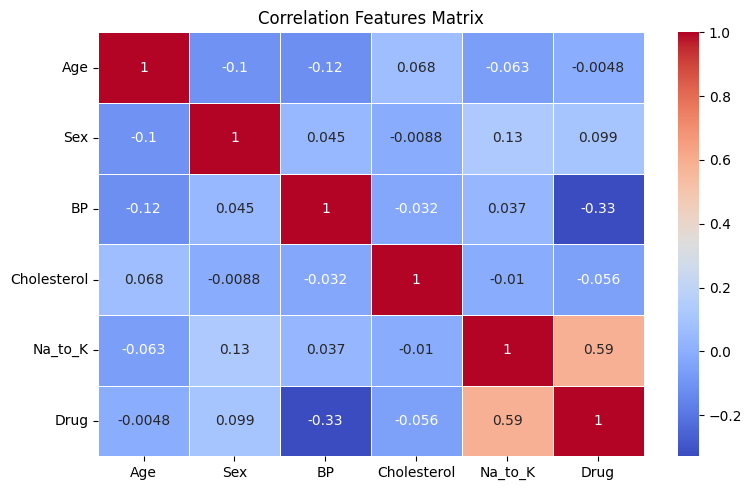

In [0]:
plt.rc('font', size = 10)
fig, ax = plt.subplots(figsize = (8, 5))
sns.heatmap(df_encoded.corr(), annot = True, cmap = 'coolwarm', linewidths = 0.5, ax = ax)
ax.set_title('Correlation Features Matrix')
plt.tight_layout()
plt.show()

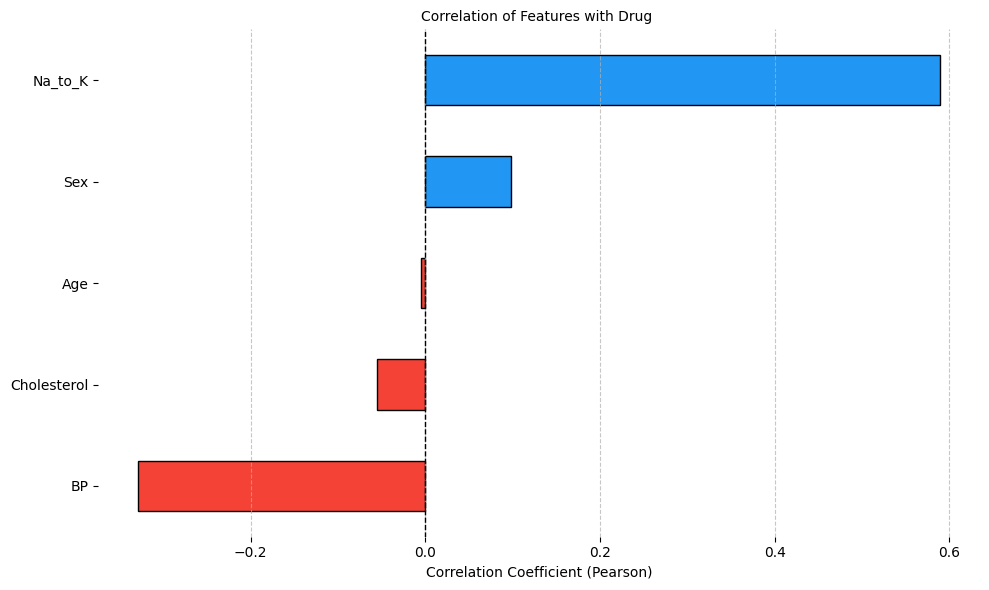

In [0]:
# Collecting data
correlation_values = df_encoded.corr()['Drug']

if 'Drug' in  correlation_values.index:
    plot_data = correlation_values.drop('Drug').sort_values()

else:
    plot_data = correlation_values.sort_values()


# Colors 
colors = ['#2196f3' if x > 0 else '#f44336' for x in plot_data]

# Figure
plt.figure(figsize = (10, 6))

# Plot
plot_data.plot(
    kind = 'barh', 
    color = colors, 
    edgecolor = 'black'
)

plt.title('Correlation of Features with Drug ', fontsize = 10)
plt.xlabel('Correlation Coefficient (Pearson)', fontsize = 10)
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 1)
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

sns.despine(left = True, bottom = True) 

plt.tight_layout()
plt.show()

### Extract the input features and labels from the data set

In [0]:
X = df_encoded.drop(columns = ['Drug']).copy()
y = df_encoded['Drug'].copy()

### Selected features an train test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 33)
print(f'The shape X_train: {X_train.shape}')
print(f'The shape y_train: {y_train.shape}')
print(f'The shape X_test: {X_test.shape}')
print(f'The shape y_test: {y_test.shape}')

The shape X_train: (140, 5)
The shape y_train: (140,)
The shape X_test: (60, 5)
The shape y_test: (60,)


#### Train data

In [0]:
X_train.head()

,Age,Sex,BP,Cholesterol,Na_to_K
133,24,0,1,1,25.786
145,61,0,1,1,9.443
93,42,1,0,0,29.271
95,36,0,0,0,11.424
68,54,0,1,1,24.658


#### Test data

In [0]:
X_test.head()

,Age,Sex,BP,Cholesterol,Na_to_K
15,16,1,2,0,15.516
171,45,0,0,0,10.017
103,56,0,1,1,8.966
119,61,1,2,1,25.475
116,67,0,1,0,9.514


### XGBoot Classification Model

In [0]:
# Create a model object
XGB = XGBClassifier(
    n_estimators = 1000,
    learning_rate = 0.01,
    max_depth = 5,
    min_child_weight = 3,
    gamma = 0.1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'multi:softprob',
    eval_metric = 'mlogloss',
    random_state = 33,    
)

# Train the model in the training data
XGB.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [0]:
# Predict the target variable in the test data
y_pred = XGB.predict(X_test)
# Collecting the probabilities of the model classifications
y_prob = XGB.predict_proba(X_test)

### Model Evaluation

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         5
           3       1.00      0.95      0.97        19
           4       1.00      1.00      1.00        27

    accuracy                           0.98        60
   macro avg       0.95      0.99      0.97        60
weighted avg       0.99      0.98      0.98        60



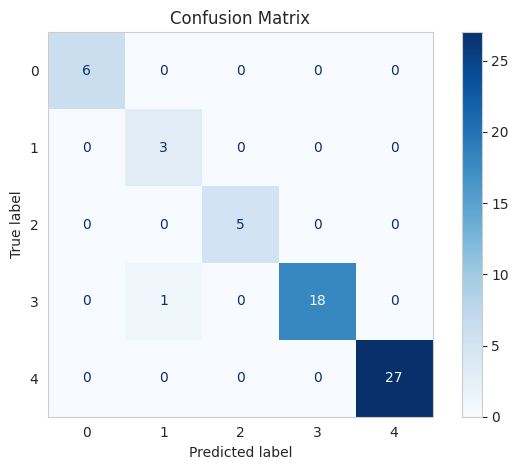

In [0]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels = ['0', '1', '2', '3', '4'], 
    cmap = 'Blues', 
    values_format = 'd'
)

plt.grid(False) 
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [0]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob, multi_class = 'ovr'):.2f}')

Accuracy: 0.98
AUC-ROC: 1.00


In [0]:
importances = pd.Series(XGB.feature_importances_, index=X_train.columns)
importances

Age            0.107102
Sex            0.042560
BP             0.321860
Cholesterol    0.116510
Na_to_K        0.411968
dtype: float32

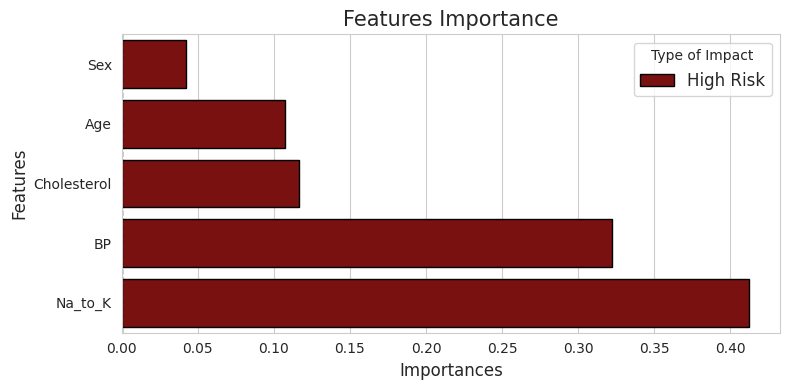

In [0]:
# Data collect
data_ax = importances.sort_values().reset_index()
data_ax.columns = ['Feature', 'Importances']


data_ax['Impact'] = data_ax['Importances'].apply(lambda x: 'High Risk' if x > 0 else 'Low Risk')

# Figure
plt.figure(figsize = (8, 4))
sns.set_style('whitegrid')

# Barplot
sns.barplot(
    data = data_ax,
    y = 'Feature',
    x = 'Importances',
    edgecolor = 'black',
    hue = 'Impact',
    dodge = False,
    palette = {'High Risk': 'darkred', 'Low Risk': 'teal'}
)

plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 1)
plt.title('Features Importance', fontsize = 15)
plt.xlabel('Importances', fontsize = 12)
plt.ylabel('Features', fontsize = 12)
plt.legend(title = 'Type of Impact', loc = 'upper right', fontsize = 12)

plt.tight_layout()
plt.show()


### Conclusion

---

- The developed **XGBoost** model demonstrates exceptional predictive robustness and reliability. With an overall **Accuracy of 98%** and a perfect **Area Under the Curve (AUC-ROC) of 1.00**, the classifier exhibits absolute discriminatory competence. These metrics indicate that the model has successfully captured the underlying patterns of the dataset, creating precise decision boundaries for nearly all patient profiles.

- The analysis of **Feature Importance** reveals that the predictive logic is primarily driven by physiological biomarkers rather than demographic data:
    - **`Na_to_K` (41.2%)** and **`BP` (32.2%)** are the dominant predictors, together accounting for over **73%** of the model's decision power. This suggests that the classification is heavily dependent on specific chemical thresholds and blood pressure levels, acting as strong deterministic rules.
    - **`Cholesterol` (11.6%)** and **`Age` (10.7%)** serve as secondary factors, likely refining the decision in borderline cases where the primary biomarkers are not definitive.
    - **`Sex` (4.2%)** has the lowest impact, indicating that gender is the least discriminative factor for this specific problem.


- Detailed performance metrics per class confirm the model's stability:
    - Classes **0, 2, and 4** achieved flawless scores (**1.00 Precision and Recall**), meaning the model made zero errors in identifying these specific groups.
    - **Class 3** showed strong performance (F1-Score 0.97), with only a minimal margin of error (Recall 0.95) over a solid support of 19 instances.
    - **Class 1** presented a Recall of 1.00 (capturing all true instances) but a lower Precision (0.75). However, given the extremely low support (only 3 samples), this variance represents a single false positive and is statistically negligible in the context of the overall model performance.


- In summary, the model successfully effectively prioritized quantitative health indicators (`Na_to_K`, `BP`) to achieve near-perfect classification, demonstrating that the problem follows a structured, non-linear biological logic that the XGBoost architecture was able to map completely.